# Deep Learning with PyTorch : Build a Generative Adversarial Network

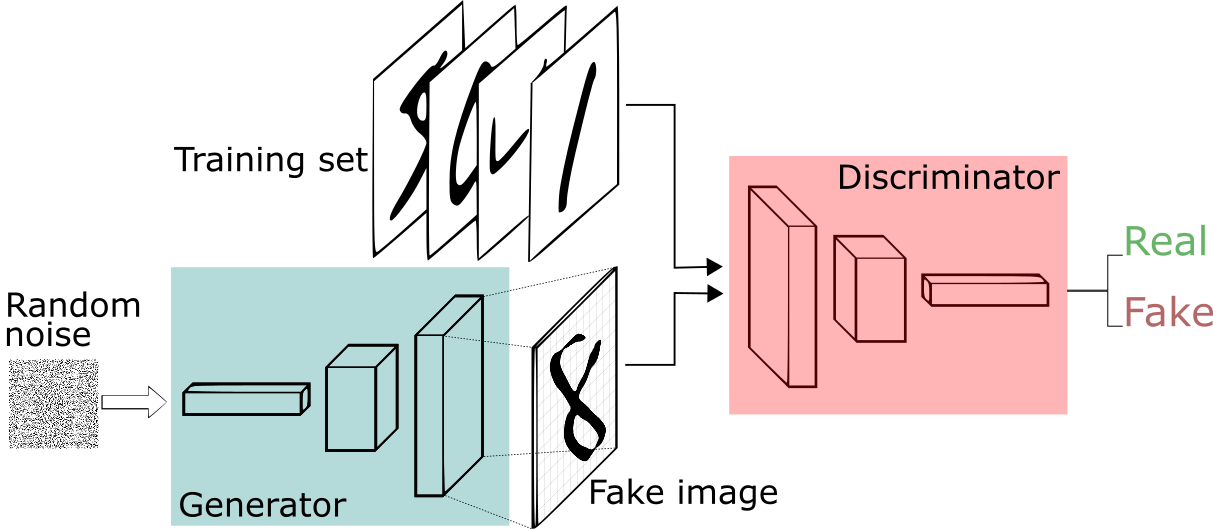

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda' #image=image.to(device)
                #device that you will use to transfer your image to GPU device

batch_size=128  #will be used in trainloader , training loop
noise_dim=64   #generator model

#optimizer parameters
lr=0.0002
beta_1= 0.5
beta_2= 0.99

#training variable s
epochs=20


# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs =T.Compose ([ T.RandomRotation((-20,+20)),
                        T.ToTensor() #(h,w,c)->(c,h,w)
                        ])

In [ ]:
trainset=datasets.MNIST('MNSIT/', download=True, train=True, transform=train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNSIT/MNIST/raw/train-images-idx3-ubyte.gz to MNSIT/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNSIT/MNIST/raw/train-labels-idx1-ubyte.gz to MNSIT/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNSIT/MNIST/raw/t10k-images-idx3-ubyte.gz to MNSIT/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNSIT/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNSIT/MNIST/raw



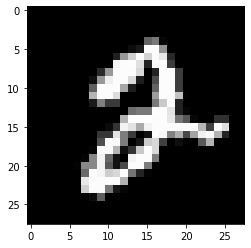

In [ ]:
image, label= trainset[5]
plt.imshow(image.squeeze(),cmap='gray')

# Load Dataset Into Batches

In [ ]:
print ("total imagespresent in trainset are :", len(trainset))

total imagespresent in trainset are : 60000


In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader= DataLoader(trainset, batch_size=batch_size, shuffle =True)

In [ ]:
print ("total number of batches in trainloader :", len(trainloader))

total number of batches in trainloader : 469


In [ ]:
dataiter= iter(trainloader)

In [ ]:
images,_= dataiter.next()
print(images.shape)
torch.Size([128,1,28,28])

torch.Size([128, 1, 28, 28])


torch.Size([128, 1, 28, 28])

In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

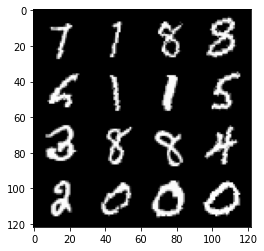

In [ ]:
show_tensor_images(images,num_images=16)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
#it is a binary classifier , yes or no real or fake image

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2) #activation function, lower limit=0.2
  )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self) :
      super(Discriminator,self).__init__()

      self.block_1=get_disc_block(1,16,(3,3),2)
      self.block_2=get_disc_block(16,32,(5,5),2)
      self.block_3=get_disc_block(32,64,(5,5),2)

      self.flatten=nn.Flatten()
      self.linear=nn.Linear(in_features=64, out_features=1)

  def forward(self,images):

    x1=self.block_1(images)
    x2=self.block_2(x1)
    x3=self.block_3(x2)

    x4=self.flatten(x3)
    x5=self.linear(x4)

    return x5
    #here we are not using sigmoid layer , we will be using binary cross entropy with logit loss, and it takes only raw input
    #without any sigmoid activation, sigmoid layer gets applied in the loss function itself


In [ ]:
#summary of the model
D=Discriminator()
D.to(device)

summary(D, input_size= (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [ ]:
#convolution layers take in input as batchsize, channel height and width covention
#our input is rightnow in batchsize, noise_dim convention
#so we'll reshape it (bs, 64 ,1,1) (bs , noise_dim, height , width)

In [ ]:
def get_gen_block(in_channels, out_channels,kernel_size, stride, final_block=False):
  if final_block==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )


In [ ]:
from typing_extensions import final
class Generator(nn.Module):

  def __init__(self,noise_dim):
    super(Generator,self).__init__()

    self.noise_dim=noise_dim
    self.block_1=get_gen_block(noise_dim, 256,(3,3),2)
    self.block_2=get_gen_block(256,128, (4,4),1)
    self.block_3=get_gen_block(128,64,(3,3),2)

    self.block_4=get_gen_block(64,1,(4,4),2, final_block=True)

  def forward(self,r_noise_vec):
    #(bs,noise_dim)->(bs,noise_dim,1,1)

    x=r_noise_vec.view(-1,self.noise_dim,1,1)

    x1=self.block_1(x)
    x2= self.block_2(x1)
    x3= self.block_3(x2)
    x4= self.block_4(x3)

    return x4

In [ ]:
G= Generator(noise_dim)
G.to(device)
summary (G, input_size=(1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:

# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D= D.apply(weights_init)
G= G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss (disc_pred):
  criterion =nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(disc_pred)
  loss=criterion(disc_pred,ground_truth)
  return loss

def fake_loss (disc_pred):
  criterion =nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(disc_pred)
  loss=criterion(disc_pred,ground_truth)
  return loss

In [ ]:
D_opt=torch.optim.Adam(D.parameters(), lr=lr,betas=(beta_1,beta_2))
G_opt=torch.optim.Adam(G.parameters(), lr=lr,betas=(beta_1,beta_2))

# Training Loop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 1 | D_loss : 0.0 | G_loss : 0.6841622432157684


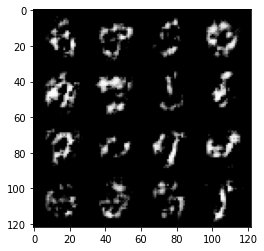

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 2 | D_loss : 0.0 | G_loss : 0.706969365000979


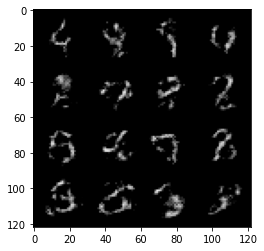

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 3 | D_loss : 0.0 | G_loss : 0.752948350362432


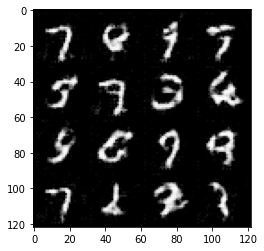

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 4 | D_loss : 0.0 | G_loss : 0.7978889469398873


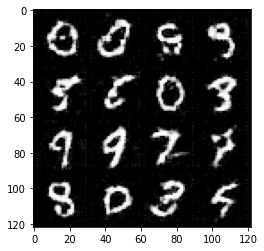

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 5 | D_loss : 0.0 | G_loss : 0.8339370688649891


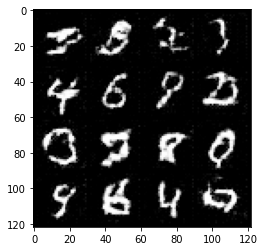

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 6 | D_loss : 0.0 | G_loss : 0.8499249610057009


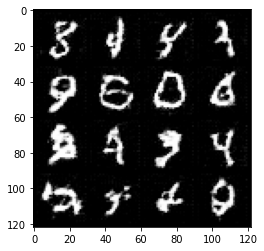

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 7 | D_loss : 0.0 | G_loss : 0.866241504642755


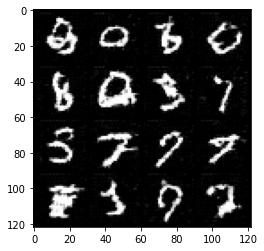

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 8 | D_loss : 0.0 | G_loss : 0.8737622068634928


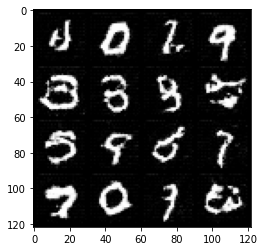

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 9 | D_loss : 0.0 | G_loss : 0.866369509112352


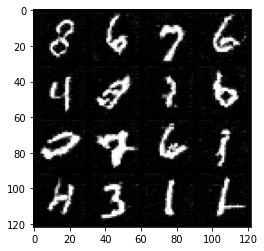

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 10 | D_loss : 0.0 | G_loss : 0.8656986982329313


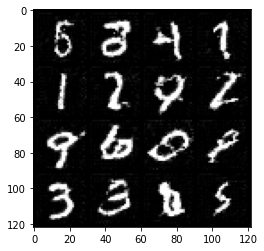

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 11 | D_loss : 0.0 | G_loss : 0.8603376655944629


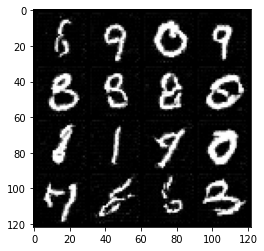

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 12 | D_loss : 0.0 | G_loss : 0.8583966904103375


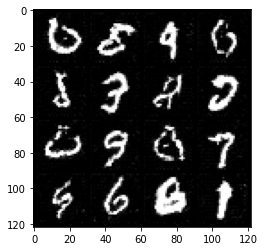

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 13 | D_loss : 0.0 | G_loss : 0.8601767005188379


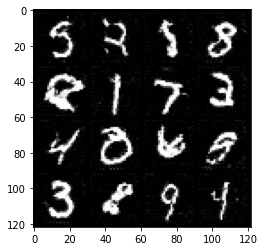

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 14 | D_loss : 0.0 | G_loss : 0.8529817308190026


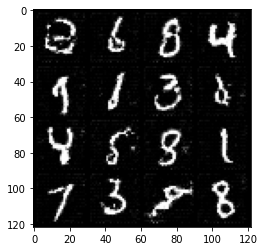

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 15 | D_loss : 0.0 | G_loss : 0.8530028970765152


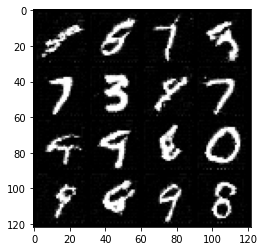

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 16 | D_loss : 0.0 | G_loss : 0.8492254411487945


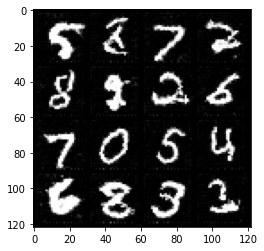

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 17 | D_loss : 0.0 | G_loss : 0.8479940751468195


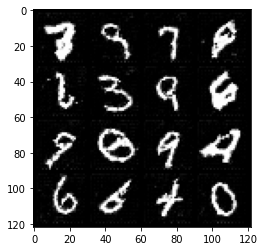

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 18 | D_loss : 0.0 | G_loss : 0.8476817123671331


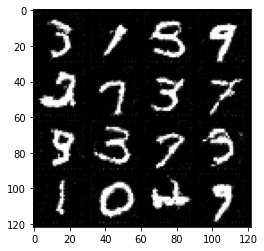

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 19 | D_loss : 0.0 | G_loss : 0.8437661329057934


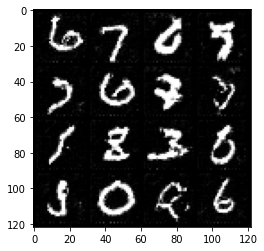

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch : 20 | D_loss : 0.0 | G_loss : 0.8467090747503838


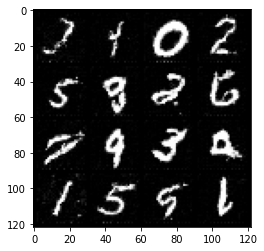

In [ ]:
for i in range(epochs):

  total_d_loss=0.0
  total_g_loss=0.0

  for real_img,_ in trainloader:
    real_img=real_img.to(device)
    noise=torch.randn(batch_size, noise_dim, device=device)

    #find loss and update weightsfor D
    D_opt.zero_grad()

    fake_img=G(noise)
    D_pred=D(fake_img)
    D_fake_loss =fake_loss(D_pred)

    D_pred= D(real_img)
    D_real_loss=real_loss(D_pred)

    D_loss=(D_fake_loss+ D_real_loss)/2

    D_loss.backward()
    D_opt.step()

    #find loss and update weights for G

    G_opt.zero_grad()

    noise= torch.randn(batch_size,noise_dim,device=device)

    fake_img=G(noise)
    D_pred=D(fake_img)
    G_loss=real_loss(D_pred)

    total_g_loss+=G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss=total_d_loss/len(trainloader)
  avg_g_loss=total_g_loss/len(trainloader)

  print("Epoch : {} | D_loss : {} | G_loss : {}".format(i+1,avg_d_loss,avg_g_loss))

  show_tensor_images(fake_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


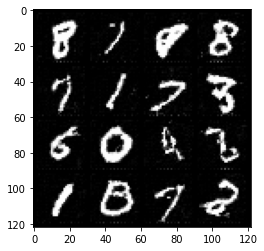

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya